LC         861
NT         175
EN         155
VU         110
CR          69
DD          32
CR (PE)      5
Name: europeanRegionalRedListCategory, dtype: int64
dict_keys(['LC', 'NT', 'EN', 'VU', 'CR', 'DD', 'CR (PE)'])
/usr/local/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
0.6312056737588653
0.624113475177305
0.29537366548042704
0.22419928825622776
0.6476868327402135


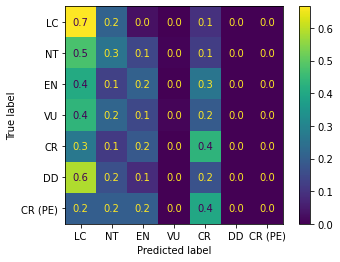

In [2]:
from sklearn.pipeline import Pipeline
import pandas as pd
import category_encoders as ce
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt  

eu_red_list = pd.read_csv("/Users/kristianjespersen/Documents/IKT/6_semester/ITMAL/itmal_4_redlist/datasets_ready/eu_red_list_train.csv")
print(eu_red_list['europeanRegionalRedListCategory'].value_counts())

target_mapping = {'LC': 0, 'NT': 1, 'EN': 2, 'VU': 3, 'CR': 4, 'DD': 5, 'CR (PE)': 6}
print(target_mapping.keys())

encoder_pipeline = Pipeline([
  ('featureEncoding', ce.OneHotEncoder(cols=['speciesGroup','taxonomicRankKingdom','taxonomicRankPhylum','taxonomicRankClass','taxonomicRankOrder','taxonomicRankFamily','taxonomicRankGenus','taxonomicRankSpecies','endemicToEurope','populationTrend','useAndTrade'], return_df=True)),
  ('targetEncoding', ce.OrdinalEncoder(cols=['europeanRegionalRedListCategory'], mapping=[{'col': 'europeanRegionalRedListCategory',      'mapping': target_mapping }], return_df=True))
])

encoded = encoder_pipeline.fit_transform(eu_red_list)
X = encoded.iloc[:,:-1].values
y = encoded.iloc[:,-1].values


def avg_k_fold_confusion_matrix(model,X,y,k_folds):
  confusion_matrixes = []
  accuracy_scores = []
  #KFold method generates index ranges for splitting
  folder = StratifiedKFold(n_splits=k_folds)
  for training_index, testing_index in folder.split(X,y):
    X_train, X_test = X[training_index], X[testing_index]
    y_train, y_test = y[training_index], y[testing_index]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    matrix = confusion_matrix(y_test, y_pred,normalize='true')
    confusion_matrixes.append(matrix)
    accuracy_scores.append(accuracy_score(y_test,y_pred ))
  mean_conf_matrix = np.mean(confusion_matrixes, axis=0)
  to_display = ConfusionMatrixDisplay(mean_conf_matrix, display_labels=target_mapping.keys())
  to_display.plot(values_format='.1f')
  return zip(confusion_matrixes,accuracy_scores)

for matrix, score in avg_k_fold_confusion_matrix(MLPClassifier(), X,y,5):
  print(score)